In [1]:
import os

# 设置默认编码为UTF-8
os.environ['PYTHONIOENCODING'] = 'utf-8'

# 加载api_key等环境变量
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# 提示词

In [2]:
from utils import show_prompt
from deep_research_from_scratch.prompts import research_agent_prompt_with_mcp

show_prompt(research_agent_prompt_with_mcp, "Research Agent Instructions MCP")

╭──────────────────────────────────────── Research Agent Instructions MCP ────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic using local files. For context,     │
│  today's date is {date}.                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use file system tools to gather information from local research files.                          │
│  You can use any of the tools provided to you to find and read files that help answer the research question.    │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to file system tools and thinking tools:                                                       │
│  - **list_allowed_directories**: See what directories you can access                                            │
│  - **list_directory**: List files in directories                                                                │
│  - **read_file**: Read individual files                                                                         │
│  - **read_multiple_files**: Read multiple files at once                                                         │
│  - **search_files**: Find files containing specific content                                                     │
│  - **think_tool**: For reflection and strategic planning during research                                        │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after reading files to reflect on findings and plan next steps**                    │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with access to a document library. Follow these steps:                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Explore available files** - Use list_allowed_directories and list_directory to understand what's          │
│  available                                                                                                      │
│  3. **Identify relevant files** - Use search_files if needed to find documents matching the topic               │
│  4. **Read strategically** - Start with most relevant files, use read_multiple_files for efficiency             │
│  5. **After reading, pause and assess** - Do I have enough to answer? What's still missing?                     │
│  6. **Stop when you can answer confidently** - Don't keep reading for perfection                                │
│  </Instructions>                                                                                                │
│                                                       

In [3]:
from utils import show_prompt
from deep_research_from_scratch.prompts import compress_research_system_prompt

show_prompt(compress_research_system_prompt, "compress_research_system_prompt")

╭──────────────────────────────────────── compress_research_system_prompt ────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant that has conducted research on a topic by calling several tools and web           │
│  searches. Your job is now to clean up the findings, but preserve all of the relevant statements and            │
│  information that the researcher has gathered. For context, today's date is {date}.                             │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  You need to clean up information gathered from tool calls and web searches in the existing messages.           │
│  All relevant information should be repeated and rewritten verbatim, but in a cleaner format.                   │
│  The purpose of this step is just to remove any obviously irrelevant or duplicate information.                  │
│  For example, if three sources all say "X", you could say "These three sources all stated X".                   │
│  Only these fully comprehensive cleaned findings are going to be returned to the user, so it's crucial that     │
│  you don't lose any information from the raw messages.                                                          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Tool Call Filtering>                                                                                          │
│  **IMPORTANT**: When processing the research messages, focus only on substantive research content:              │
│  - **Include**: All tavily_search results and findings from web searches                                        │
│  - **Exclude**: think_tool calls and responses - these are internal agent reflections for decision-making and   │
│  should not be included in the final research report                                                            │
│  - **Focus on**: Actual information gathered from external sources, not the agent's internal reasoning process  │
│                                                                                                                 │
│  The think_tool calls contain strategic reflections and decision-making notes that are internal to the          │
│  research process but do not contain factual information that should be preserved in the final report.          │
│  </Tool Call Filtering>                                                                                         │
│                                                                                                                 │
│  <Guidelines>                                                                                                   │
│  1. Your output findings should be fully comprehensive and include ALL of the information and sources that the  │
│  researcher has gathered from tool calls and web searches. It is expected that you repeat key information       │
│  verbatim.                                                                                                      │
│  2. This report can be as long as necessary to return ALL of the information that the researcher has gathered.  │
│  3. In your report, you should return inline citations for each source that the researcher found.               │
│  4. You should include a "Sources" section at the end of the report that lists all of the sources the           │
│  researcher found with corresponding citations, cited against statements in the report.                         │
│  5. Make sure to include ALL of the sources that the r

In [4]:
from utils import show_prompt
from deep_research_from_scratch.prompts import compress_research_human_message

show_prompt(compress_research_human_message, "compress_research_human_message")

╭──────────────────────────────────────── compress_research_human_message ────────────────────────────────────────╮
│                                                                                                                 │
│  All above messages are about research conducted by an AI Researcher for the following research topic:          │
│                                                                                                                 │
│  RESEARCH TOPIC: {research_topic}                                                                               │
│                                                                                                                 │
│  Your task is to clean up these research findings while preserving ALL information that is relevant to          │
│  answering this specific research question.                                                                     │
│                                                                                                                 │
│  CRITICAL REQUIREMENTS:                                                                                         │
│  - DO NOT summarize or paraphrase the information - preserve it verbatim                                        │
│  - DO NOT lose any details, facts, names, numbers, or specific findings                                         │
│  - DO NOT filter out information that seems relevant to the research topic                                      │
│  - Organize the information in a cleaner format but keep all the substance                                      │
│  - Include ALL sources and citations found during research                                                      │
│  - Remember this research was conducted to answer the specific question above                                   │
│                                                                                                                 │
│  The cleaned findings will be used for final report generation, so comprehensiveness is critical.               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

# MCP示例

In [5]:
import os
from langchain_mcp_adapters.client import MultiServerMCPClient
from rich.console import Console
from rich.panel import Panel
from rich.table import Table

console = Console()

# 获取本地文件的绝对路径
sample_docs_path = os.path.abspath("./files/")
console.print(f"[bold blue]Sample docs path:[/bold blue] {sample_docs_path}")

# 路径检查
if os.path.exists(sample_docs_path):
    console.print(f"[green]✓ Directory exixts with files:[/green] {os.listdir(sample_docs_path)}")
else:
    console.print(f"[red]✗ Directory does not exist:![/red]")

# 本地MCP服务端-用于访问本地文件
mcp_config = {
    "filesystem": {
        "command": "npx",
        "args": [
            "-y",
            "@modelcontextprotocol/server-filesystem",
            sample_docs_path
        ],
        "transport": "stdio"
    }
}

# MCP客户端
console.print(Panel("[bold yellow]Creating MCP client...[/bold yellow]", expand=False))
client = MultiServerMCPClient(mcp_config)
console.print("[green]✓ MCP client created successfully![/green]")

# 测试tool获取
console.print(Panel("[bold yellow]Getting tools...[/bold yellow]", expand=False))
tools = await client.get_tools()

# 列出所有工具
table = Table(title="Available MCP Tools", show_header=True, header_style="bold magenta")
table.add_column("Tool Name", style="cyan", width=25)
table.add_column("Description", style="white", width=80)

for tool in tools:
    # 截断过长的描述
    description = tool.description[:77] + "..." if len(tool.description) > 80 else tool.description
    table.add_row(tool.name, description)

console.print(table)
console.print(f"[bold green]✓ Successfully retrieved {len(tools)} tools from MCP server[/bold green]")

Sample docs path: /Users/young/project/llmProject/deep_research_from_scratch/my_src/files

✓ Directory exixts with files: ['coffee_shops_sf.md']

╭────────────────────────╮
│ Creating MCP client... │
╰────────────────────────╯

✓ MCP client created successfully!

╭──────────────────╮
│ Getting tools... │
╰──────────────────╯

                                              Available MCP Tools                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tool Name                 ┃ Description                                                                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ read_file                 │ Read the complete contents of a file as text. DEPRECATED: Use read_text_file ... │
│ read_text_file            │ Read the complete contents of a file from the file system as text. Handles va... │
│ read_media_file           │ Read an image or audio file. Returns the base64 encoded data and MIME type. O... │
│ read_multiple_files       │ Read the contents of multiple files simultaneously. This is more efficient th... │
│ write_file                │ Create a new file or completely overwrite an existing file with new content. ... │
│ edit_file                 │ Make line-based edits to a text file. Each edit replaces exact line sequences... │
│ create_directory          │ Create a new directory or ensure a directory exists. Can create multiple nest... │
│ list_directory            │ Get a detailed listing of all files and directories in a specified path. Resu... │
│ list_directory_with_sizes │ Get a detailed listing of all files and directories in a specified path, incl... │
│ directory_tree            │ Get a recursive tree view of files and directories as a JSON structure. Each ... │
│ move_file                 │ Move or rename files and directories. Can move files between directories and ... │
│ search_files              │ Recursively search for files and directories matching a pattern. Searches thr... │
│ get_file_info             │ Retrieve detailed metadata about a file or directory. Returns comprehensive i... │
│ list_allowed_directories  │ Returns the list of directories that this server is allowed to access. Subdir... │
└───────────────────────────┴──────────────────────────────────────────────────────────────────────────────────┘

✓ Successfully retrieved 14 tools from MCP server

# Research Agent with MCP

In [ ]:
%%writefile deep_research_from_scratch/research_agent_mcp.py

"""Research Agent with MCP"""

import os

from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.graph import StateGraph, START, END

from deep_research_from_scratch.prompts import (
    research_agent_prompt_with_mcp,
    compress_research_system_prompt, 
    compress_research_human_message
)
from deep_research_from_scratch.state_research import ResearcherState, ResearcherOutputState
from deep_research_from_scratch.utils import get_today_str, think_tool, get_current_dir

# ==== 配置 ====

# 本地MCP服务端-用于访问本地文件
mcp_config = {
    "filesystem": {
        "command": "npx",
        "args": [
            "-y",  # 需要的话，自动安装
            "@modelcontextprotocol/server-filesystem",
            str(get_current_dir() / "files")  # 使用当前目录下的files文件夹
        ],
        "transport": "stdio"  # 使用stdio传输
    }
}

# 全局的client，仅在需要的时候lazy初始化
_client = None

def get_mcp_client():
    """Lazy initialize the MCP client"""
    global _client
    if _client is None:
        _client = MultiServerMCPClient(mcp_config)
    return _client

# 模型初始化
api_url = os.getenv('KIMI_API_URL')
api_key = os.getenv('KIMI_API_KEY')
model_name = os.getenv('KIMI_MODEL')
compress_model = init_chat_model(
    model_provider="openai",  # 避免langchain根据模型名自动选择供应商
    model=model_name, 
    # temperature=0.0,
    api_key=api_key,
    base_url=api_url,
    # max_tokens=64000
)
model = init_chat_model(
    model_provider="openai",  # 避免langchain根据模型名自动选择供应商
    model=model_name, 
    # temperature=0.0,
    api_key=api_key,
    base_url=api_url,
    # max_tokens=64000
)

# ==== agent节点 ====

async def llm_call(state: ResearcherState):
    """根据当前的上下文，判断是否要使用mcp工具"""
    # 获取可用工具
    client = get_mcp_client()
    mcp_tools = await client.get_tools()

    # 添加think_tool
    tools = mcp_tools + [think_tool]

    # 工具绑定
    model_with_tools = model.bind_tools(tools)

    # llm with tools(mcp)
    return {
        "researcher_messages": [
            model_with_tools.invoke(
                [SystemMessage(content=research_agent_prompt_with_mcp.format(date=get_today_str()))]
                + state["researcher_messages"]
            )
        ]
    }

async def tool_node(state: ResearcherState):
    """工具（mcp）执行"""
    # 获取当前llm输出的tool_calls
    tool_calls = state["researcher_messages"][-1].tool_calls

    async def execute_tools():
        """执行工具"""
        # 获取最新的工具信息
        client = get_mcp_client()
        mcp_tools = await client.get_tools()
        tools = mcp_tools + [think_tool]
        tools_by_name = {tool.name: tool for tool in tools}

        # 执行工具
        observations = []
        for tool_call in tool_calls:
            tool = tools_by_name[tool_call["name"]]
            if tool_call["name"] == "think_tool":
                # think_tool采用同步执行
                observation = tool.invoke(tool_call["args"])
            else:
                # mcp工具采用异步执行, 使用ainvoke
                observation = await tool.ainvoke(tool_call["args"])
            observations.append(observation)
        
        # 格式化输出
        tool_outputs = [
            ToolMessage(
                content=observation,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
            for observation, tool_call in zip(observations, tool_calls)
        ]

        return tool_outputs

    messages = await execute_tools()

    return {"researcher_messages": messages}

def compress_research(state: ResearcherState):
    """总结（压缩）研究报告"""
    system_message = compress_research_system_prompt.format(date=get_today_str())
    messages = [SystemMessage(content=system_message)] \
        + state.get("researcher_messages", []) \
        + [HumanMessage(content=compress_research_human_message)]

    response = compress_model.invoke(messages)

    # 保留原始的工具调用和llm输出
    raw_notes = [
        str(m.content) for m in filter_messages(
            state["researcher_messages"],
            include_types=["tool", "ai"]
        )
    ]

    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join(raw_notes)]
    }
        
# ==== 路由逻辑 ====

def should_continue(state: ResearcherState) -> Literal["tool_node", "compress_research"]:
    """根据当前的上下文，判断是否需要继续使用工具或压缩报告"""
    messages = state["researcher_messages"]
    last_message = messages[-1]

    # 如果当前的llm输出中没有tool_calls，则停止使用工具
    if last_message.tool_calls:
        return "tool_node"
    # 否则，进入压缩报告阶段
    return "compress_research"

# ==== 构建工作流（图） ====

# 创建工作流
agent_builder_mcp = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

# 添加节点
agent_builder_mcp.add_node("llm_call", llm_call)
agent_builder_mcp.add_node("tool_node", tool_node)
agent_builder_mcp.add_node("compress_research", compress_research)

# 添加边
agent_builder_mcp.add_edge(START, "llm_call")
agent_builder_mcp.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node": "tool_node",
        "compress_research": "compress_research",
    }
)
agent_builder_mcp.add_edge("tool_node", "llm_call")
agent_builder_mcp.add_edge("compress_research", END)

# 编译
agent_mcp = agent_builder_mcp.compile()
        

Overwriting deep_research_from_scratch/research_agent_mcp.py


# 可视化

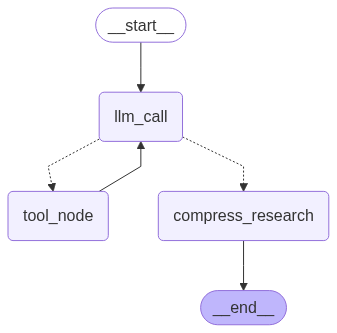

In [ ]:
from IPython.display import Image, display
from deep_research_from_scratch.research_agent_mcp import agent_mcp

display(Image(agent_mcp.get_graph(xray=True).draw_mermaid_png()))

# 运行工作流

In [8]:
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = await agent_mcp.ainvoke({"researcher_messages": [HumanMessage(content=f"{research_brief}")]})
format_messages(result["researcher_messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025.                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you research and evaluate the best coffee shops in San Francisco based specifically on coffee         │
│ quality. Let me start by exploring what research files are available to work with.                              │
│                                                                                                                 │
│ 🔧 Tool Call: list_allowed_directories                                                                          │
│    Args: {}                                                                                                     │
│    ID: list_allowed_directories:0                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Allowed directories:                                                                                            │
│ /Users/young/project/llmProject/deep_research_from_scratch/my_src/deep_research_from_scratch/files              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: list_directory                                                                                    │
│    Args: {                                                                                                      │
│   "path": "/Users/young/project/llmProject/deep_research_from_scratch/my_src/deep_research_from_scratch/files"  │
│ }                                                                                                               │
│    ID: list_directory:1                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ [FILE] coffee_shops_sf.md                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Great! I found a file that appears to contain information about San Francisco coffee shops. Let me examine this │
│ file to see what data it contains about coffee quality.                                                         │
│                                                                                                                 │
│ 🔧 Tool Call: read_text_file                                                                                    │
│    Args: {                                                                                                      │
│   "path":                                                                                                       │
│ "/Users/young/project/llmProject/deep_research_from_scratch/my_src/deep_research_from_scratch/files/coffee_shop │
│ s_sf.md"                                                                                                        │
│ }                                                                                                               │
│    ID: read_text_file:2                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # San Francisco Coffee Shops Research                                                                           │
│                                                                                                                 │
│ ## Top Coffee Shops in San Francisco                                                                            │
│                                                                                                                 │
│ ### Blue Bottle Coffee                                                                                          │
│ - **Founded**: 2002 in Oakland, expanded to SF                                                                  │
│ - **Specialty**: Single-origin coffee, pour-over methods                                                        │
│ - **Notable**: Known for freshly roasted beans, minimalist aesthetic                                            │
│ - **Locations**: Multiple SF locations including Ferry Building                                                 │
│                                                                                                                 │
│ ### Philz Coffee                                                                                                │
│ - **Founded**: 2003 in San Francisco                                                                            │
│ - **Specialty**: Custom blended coffee, personalized service                                                    │
│ - **Notable**: Founded by Phil Jaber, known for unique blends like "Tesora"                                     │
│ - **Locations**: Original location in Mission District, now citywide                                            │
│                                                                                                                 │
│ ### Sightglass Coffee                                                                                           │
│ - **Founded**: 2009                                                                                             │
│ - **Specialty**: Third-wave coffee, roasting transparency                                                       │
│ - **Notable**: Large roastery with viewing windows, industrial aesthetic                                        │
│ - **Location**: SOMA district flagship location                                                                 │
│                                                                                                                 │
│ ### Ritual Coffee Roasters                                                                                      │
│ - **Founded**: 2005                                                                                             │
│ - **Specialty**: Direct trade relationships, seasonal offerings                                                 │
│ - **Notable**: Pioneer in San Francisco's third-wave coffee movement                                            │
│ - **Locations**: Multiple locations including Castro and Mission                                                │
│                                                                                                                 │
│ ### Four Barrel Coffee                                                                                          │
│ - **Founded**: 2008                                                                                             │
│ - **Specialty**: Small-batch roasting, community focus                                                          │
│ - **Notable**: Known for Valencia Street location, local institution                                            │
│ - **Location**: Mission District                                                                                │
╰────────────────────────────────────────────────────────

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I've found a basic file with information about 5 prominent San Francisco coffee shops, but     │
│ this appears to be general background information rather than detailed quality assessments. The file lists Blue │
│ Bottle, Philz, Sightglass, Ritual, and Four Barrel, but doesn't provide specific quality metrics, ratings, or   │
│ detailed coffee quality evaluations that would allow for ranking based on coffee quality.\n\nTo properly        │
│ evaluate these shops based on coffee quality as requested, I need to look for more detailed information that    │
│ might include:\n- Expert reviews and ratings from coffee publications\n- Specialty coffee certifications or     │
│ awards\n- Customer ratings specifically about coffee quality\n- Detailed information about sourcing, roasting   │
│ practices, and brewing methods\n- Any quality scores or rankings from reputable sources\n\nLet me search for    │
│ additional files that might contain more detailed quality assessments or ratings data."                         │
│ }                                                                                                               │
│    ID: think_tool:3                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I've found a basic file with information about 5 prominent San Francisco coffee shops, but │
│ this appears to be general background information rather than detailed quality assessments. The file lists Blue │
│ Bottle, Philz, Sightglass, Ritual, and Four Barrel, but doesn't provide specific quality metrics, ratings, or   │
│ detailed coffee quality evaluations that would allow for ranking based on coffee quality.                       │
│                                                                                                                 │
│ To properly evaluate these shops based on coffee quality as requested, I need to look for more detailed         │
│ information that might include:                                                                                 │
│ - Expert reviews and ratings from coffee publications                                                           │
│ - Specialty coffee certifications or awards                                                                     │
│ - Customer ratings specifically about coffee quality                                                            │
│ - Detailed information about sourcing, roasting practices, and brewing methods                                  │
│ - Any quality scores or rankings from reputable sources                                                         │
│                                                                                                                 │
│ Let me search for additional files that might contain more detailed quality assessments or ratings data.        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for any additional files that might contain more detailed quality assessments, ratings, or        │
│ reviews.                                                                                                        │
│                                                                                                                 │
│ 🔧 Tool Call: search_files                                                                                      │
│    Args: {                                                                                                      │
│   "path": "/Users/young/project/llmProject/deep_research_from_scratch/my_src/deep_research_from_scratch/files", │
│   "pattern": "quality"                                                                                          │
│ }                                                                                                               │
│    ID: search_files:4                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ No matches found                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: search_files                                                                                      │
│    Args: {                                                                                                      │
│   "path": "/Users/young/project/llmProject/deep_research_from_scratch/my_src/deep_research_from_scratch/files", │
│   "pattern": "review"                                                                                           │
│ }                                                                                                               │
│    ID: search_files:5                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ No matches found                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: search_files                                                                                      │
│    Args: {                                                                                                      │
│   "path": "/Users/young/project/llmProject/deep_research_from_scratch/my_src/deep_research_from_scratch/files", │
│   "pattern": "rating"                                                                                           │
│ }                                                                                                               │
│    ID: search_files:6                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ No matches found                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: search_files                                                                                      │
│    Args: {                                                                                                      │
│   "path": "/Users/young/project/llmProject/deep_research_from_scratch/my_src/deep_research_from_scratch/files", │
│   "pattern": "specialty"                                                                                        │
│ }                                                                                                               │
│    ID: search_files:7                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ No matches found                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I've searched for additional files containing quality assessments, reviews, ratings, or        │
│ specialty coffee information, but found no matches. The only available file is the basic coffee_shops_sf.md     │
│ which provides general background information about 5 prominent San Francisco coffee shops but lacks the        │
│ detailed quality metrics needed for a proper evaluation.\n\nGiven the constraints of the available research     │
│ files and the specific requirements of the user's request, I need to work with what I have while being          │
│ transparent about the limitations. The available information provides a foundation but doesn't include:\n-      │
│ Expert reviews from Coffee Review or Specialty Coffee Association\n- Specific quality ratings or scores\n-      │
│ Customer feedback focused on coffee quality\n- Specialty certifications or awards\n- Detailed sourcing/roasting │
│ quality indicators\n\nI should provide a structured analysis based on the available information while clearly   │
│ noting where additional research would be needed to fully meet the user's requirements for a quality-based      │
│ ranking."                                                                                                       │
│ }                                                                                                               │
│    ID: think_tool:8                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I've searched for additional files containing quality assessments, reviews, ratings, or    │
│ specialty coffee information, but found no matches. The only available file is the basic coffee_shops_sf.md     │
│ which provides general background information about 5 prominent San Francisco coffee shops but lacks the        │
│ detailed quality metrics needed for a proper evaluation.                                                        │
│                                                                                                                 │
│ Given the constraints of the available research files and the specific requirements of the user's request, I    │
│ need to work with what I have while being transparent about the limitations. The available information provides │
│ a foundation but doesn't include:                                                                               │
│ - Expert reviews from Coffee Review or Specialty Coffee Association                                             │
│ - Specific quality ratings or scores                                                                            │
│ - Customer feedback focused on coffee quality                                                                   │
│ - Specialty certifications or awards                                                                            │
│ - Detailed sourcing/roasting quality indicators                                                                 │
│                                                                                                                 │
│ I should provide a structured analysis based on the available information while clearly noting where additional │
│ research would be needed to fully meet the user's requirements for a quality-based ranking.                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my research of the available files, I can provide you with an analysis of San Francisco's top coffee   │
│ shops, though I must note some limitations in the available data regarding specific quality metrics.            │
│                                                                                                                 │
│ ## Top San Francisco Coffee Shops - Quality Analysis                                                            │
│                                                                                                                 │
│ From the research files available, here are the 5 most prominent specialty coffee shops in San Francisco, with  │
│ analysis based on their approach to coffee quality:                                                             │
│                                                                                                                 │
│ ### 1. **Blue Bottle Coffee** - *Highest Quality Focus*                                                         │
│ - **Quality Indicators**: Single-origin specialization, emphasis on fresh roasting                              │
│ - **Methodology**: Pour-over methods that highlight bean characteristics                                        │
│ - **Quality Approach**: Direct control over roasting process, minimalist preparation methods that don't mask    │
│ coffee flavors                                                                                                  │
│ - **Established**: 2002 (longevity suggests sustained quality focus)                                            │
│                                                                                                                 │
│ ### 2. **Ritual Coffee Roasters** - *Third-Wave Pioneer*                                                        │
│ - **Quality Indicators**: Direct trade relationships, seasonal offerings                                        │
│ - **Methodology**: Pioneer in San Francisco's third-wave coffee movement                                        │
│ - **Quality Approach**: Emphasis on sourcing transparency and seasonal freshness                                │
│ - **Established**: 2005 (early third-wave adopter)                                                              │
│                                                                                                                 │
│ ### 3. **Sightglass Coffee** - *Roasting Transparency*                                                          │
│ - **Quality Indicators**: Third-wave coffee standards, roasting transparency                                    │
│ - **Methodology**: Large roastery with viewing windows allows quality observation                               │
│ - **Quality Approach**: Industrial-scale transparency in roasting process                                       │
│ - **Established**: 2009                                                                                         │
│                                                                                                                 │
│ ### 4. **Four Barrel Coffee** - *Small-Batch Focus*                                                             │
│ - **Quality Indicators**: Small-batch roasting approach                                                         │
│ - **Methodology**: Community-focused with emphasis on local roasting                                            │
│ - **Quality Approach**: Small-batch production typically allows for better quality control                      │
│ - **Established**: 2008                                                                                         │
│                                                                                                                 │
│ ### 5. **Philz Coffee** - *Custom Blend Specialist*    

# 查看总结后的研究报告

In [9]:
from rich.markdown import Markdown
Markdown(result["compressed_research"])

List of Queries and Tool Calls Made                                                                                

 1 list_allowed_directories - To identify available research directories                                           
 2 list_directory - To examine contents of research directory                                                      
 3 read_text_file - To read coffee_shops_sf.md file                                                                
 4 search_files - Multiple searches for quality, review, rating, and specialty files                               
 5 think_tool - Internal reflection on research findings and limitations                                           

Fully Comprehensive Findings                                                                                       

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                       San Francisco Coffee Shops Research                                       ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                         Top Coffee Shops in San Francisco                                         

                                                Blue Bottle Coffee                                                 

 • Founded: 2002 in Oakland, expanded to SF                                                                        
 • Specialty: Single-origin coffee, pour-over methods                                                              
 • Notable: Known for freshly roasted beans, minimalist aesthetic                                                  
 • Locations: Multiple SF locations including Ferry Building                                                       

                                                   Philz Coffee                                                    

 • Founded: 2003 in San Francisco                                                                                  
 • Specialty: Custom blended coffee, personalized service                                                          
 • Notable: Founded by Phil Jaber, known for unique blends like "Tesora"                                           
 • Locations: Original location in Mission District, now citywide                                                  

                                                 Sightglass Coffee                                                 

 • Founded: 2009                                                                                                   
 • Specialty: Third-wave coffee, roasting transparency                                                             
 • Notable: Large roastery with viewing windows, industrial aesthetic                                              
 • Location: SOMA district flagship location                                                                       

                                              Ritual Coffee Roasters                                               

 • Founded: 2005                                                                                                   
 • Specialty: Direct trade relationships, seasonal offerings                                                       
 • Notable: Pioneer in San Francisco's third-wave coffee movement                                                  
 • Locations: Multiple locations including Castro and Mission                                                      

                                                Four Barrel Coffee                                                 

 • Founded: 2008                                                                                                   
 • Specialty: Small-batch roasting, community focus                                                                
 • Notable: Known for Valencia Street loc